# Dimension Reduction

## Principal Components Analysis
A dataset that contains information about some factors for each country is used for the year 2019.
The dataset can be found in https://www.kaggle.com/unsdsn/world-happiness. 
First load the data and check if there are missing values.

In [1]:
#Load data
import pandas as pd
df = pd.read_csv('2019.csv')
df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [2]:
df.columns

Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')

In [3]:
print(df.shape)
df.isnull().sum()

(156, 9)


Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

### Correlation matrix
Show how variables relate to each other by the correlation matrix. 
For instance, we can see from the heatmap that Score and GDP per capita are highly correlated, while The correlation between Generosity and Score is very low. 

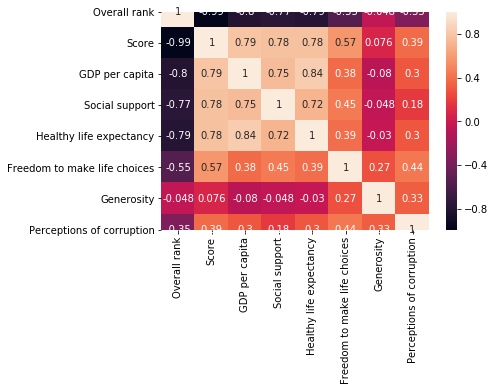

In [4]:
import seaborn as sn
sn.heatmap(df.corr(), annot=True)

### Find the PCs
Find the Principal Components that represent 80% of the variance of the data. 
First, we need to define which are the features and the target variables for this problem.
Then, scale the data and finally find the components. 

In [27]:
features = df.drop(['Country or region', 'Overall rank'], axis=1)

In [28]:
%pylab inline
import process_PCA as p
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = StandardScaler().fit_transform(features.values)
pca = PCA(random_state=0)
pca.fit(x)

Populating the interactive namespace from numpy and matplotlib


PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

### Scree plot
By plotting the cumulative explained variance when while changing the number of components, we can see when the variances reachers a threshold that we think that is enough to explain the data. And, in this way determine the number of components that are neccesary. 

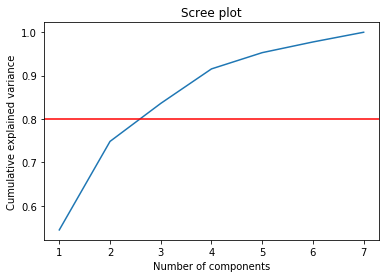

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations
threshold=0.8
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Scree plot')
plt.axhline(y=threshold, color='r', linestyle='-')
plt.show()

From the graph, we can see that the desired threshold is reached with 3 components. To the get exact value, we can see the vector for the comulative explained variance ratio. While with 2 components it can be explained around 75%, with 3 it is explained 84%. 

In [31]:
np.cumsum(pca.explained_variance_ratio_)

array([0.54464917, 0.74852619, 0.83608123, 0.91555369, 0.95299697,
       0.97761213, 1.        ])

### Interpretation 
Now that the number of components is defined, we can see the importance of each variable for the first 3 components.  

From the values of the PCs, we can conclude that:
- PC1 represents "Poor" countries  
- PC2 represents "Generous" countries
- PC3 represents "Corrupted" countries 

This is totally subjective, so you can find another definition for the components.

Observation: The Perception of Corruption Index is measure on a scale from 100 (clean) to 0 (highly corrupted).

In [113]:
n_components=3
pca = PCA(n_components=n_components)
pcs = pca.fit(x)
pd.DataFrame(data=pcs.components_, columns = features.columns, index=['PC1', 'PC2', 'PC3'])

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
PC1,-0.475861,-0.454825,-0.436582,-0.450150,-0.332201,-0.048233,-0.246511
PC2,-0.028371,-0.213377,-0.207148,-0.177856,0.362130,0.693809,0.516346
PC3,0.071505,-0.049598,0.258645,0.000873,0.106359,0.577009,-0.762416


/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


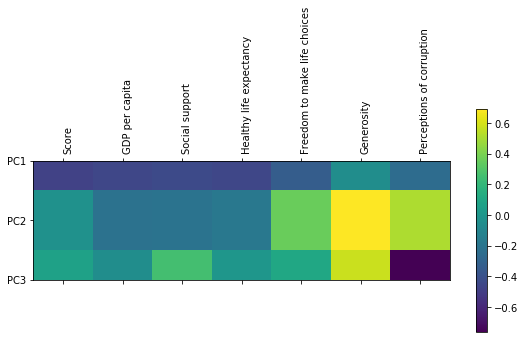

In [34]:
pca_df = pd.DataFrame(data = pca.fit_transform(x), columns = ['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df, df['Country or region']], axis = 1)
plt.matshow(pcs.components_,cmap='viridis')
components_range = np.arange(1, n_components+1, 1)
components_names = list(map(lambda x: 'PC' + str(x), components_range))
plt.yticks(range(0,n_components), components_names,fontsize=10)
plt.colorbar()
plt.xticks(range(0,len(features.columns)),features.columns,rotation=90,ha='left')
plt.tight_layout()
plt.show()

### Scatter plot
By a scatter plot we can visualize the relationship between 2 components. And analyze if the points are grouped in a certain way.   

Graph 1: PC1 vs PC2 
- We can see that Africa has high PC1, which means that countries from Africa are Poor.
- Countries that have very very low PC1, that are rich, are generous.
- Countries that are in the middle, are not rich and are not poor, are not generous. 

Graph 2: PC1 vs PC3
In this graph we can see the division between reach and poor again, but for the corruption is very spread. Seems that there is not correlation between these 2 components. A country might be poor but corrupted or not. 

Graph 3: PC2 vs PC3
This graph compares PC3(corruption) and PC2(generosity), we can can see that most of the countries are concentrated in the middle, which means that have some level of corruption and are not very generous.   
There are some exceptions:   
- 2 countries from Africa that are very genereous and not corrupted.
- 2 countries from Asia that are very generous but very corrupted.    


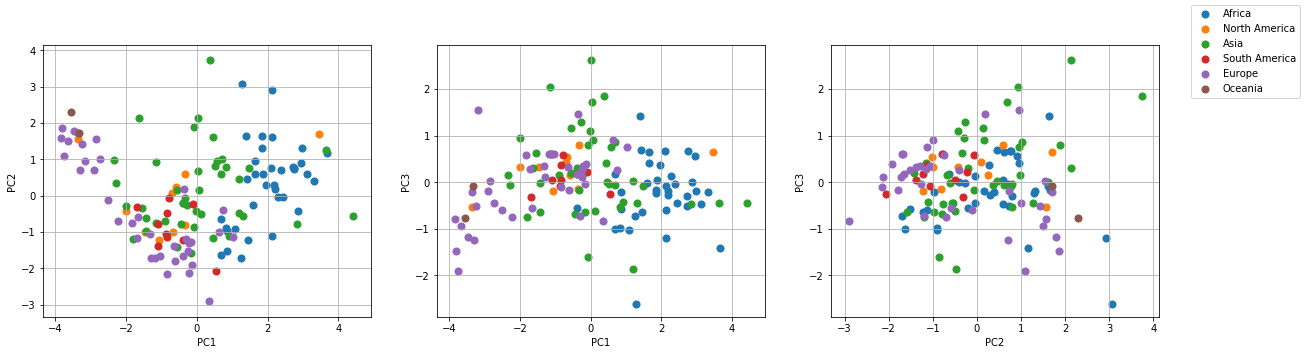

In [114]:
import geopandas
import seaborn as sns

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
merged_inner = pd.merge(left=world, right=pca_df, left_on='name',right_on='Country or region', how='inner')
targets = merged_inner.continent.unique()
colors = sns.color_palette("hls", len(targets))

def draw_components(ax, targets, colors, names, df):
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])
    for target, color in zip(targets,colors):
        indicesToKeep = df['continent'] == target
        ax.scatter(df.loc[indicesToKeep, names[0]]
                   , df.loc[indicesToKeep, names[1]]
                   , cmap = colors
                   , s = 50)
    ax.grid()
    return ax

fig, axs = plt.subplots(1,3, figsize=(20, 5))
draw_components(axs[0],targets, colors, ['PC1','PC2'], merged_inner)
draw_components(axs[1],targets, colors, ['PC1','PC3'], merged_inner)
draw_components(axs[2],targets, colors, ['PC2','PC3'], merged_inner)
fig.legend(targets)
plt.show()

### Validate
We can see if our definition of the principal components makes sense by drawing a world map and coloring the principal components. Comparing the two graphs are very similar. Thus, the definition of the principal components might be right.

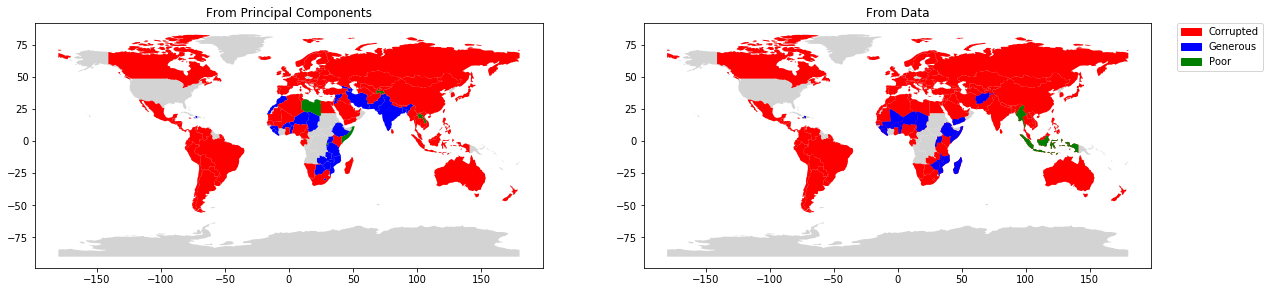

In [137]:
merged_inner['pc'] = np.where(merged_inner['PC1'] > merged_inner['PC2'], 'PC1', 'PC2')
merged_inner['pc'] = np.where(merged_inner['PC3'] > merged_inner['PC1'], 'PC3', merged_inner['pc'])
merged_inner['pc'] = np.where(merged_inner['PC3'] > merged_inner['PC2'], 'PC3', merged_inner['pc'])
pc1 = merged_inner[merged_inner['pc']=='PC1']
pc2 = merged_inner[merged_inner['pc']=='PC2']
pc3 = merged_inner[merged_inner['pc']=='PC3']

cmap = cm.get_cmap('Spectral')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 5))
world.plot(color='lightgrey', ax=ax1)
pc1.plot(ax=ax1, color='blue', label='PC1')
pc2.plot(ax=ax1, color='green', label='PC2')
pc3.plot(ax=ax1, color='red', label='PC3')
ax1.set_title('From Principal Components')

df_merged = pd.merge(left=world, right=df, left_on='name',right_on='Country or region', how='inner')
generous_countries = df_merged[df_merged['Generosity'] > 0.4]
corrupted_countries = df_merged[df_merged['Perceptions of corruption'] < 0.4]
poor_countries = df_merged[df_merged['GDP per capita'] < 0.4]

world.plot(color='lightgrey', ax=ax2)
corrupted_countries.plot(ax=ax2, color='red', label='PC3')
generous_countries.plot(ax=ax2, color='green', label='PC2')
poor_countries.plot(ax=ax2, color='blue', label='PC1')
ax2.set_title('From Data')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='The red data')
blue_patch = mpatches.Patch(color='blue', label='The blue data')
green_patch = mpatches.Patch(color='green', label='The green data')
plt.legend(handles=[red_patch, blue_patch, green_patch], labels=['Corrupted', 'Generous', 'Poor'], 
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## Exploratory Factor Analysis

In [152]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis
transformer = FactorAnalysis(random_state=0)

efa = transformer.fit_transform(features.values)
transformer.noise_variance_

array([0.85907242, 0.12395281, 0.07116752, 0.04646862, 0.01843313,
       0.00900625, 0.00848704])